In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from transformer import Decoder
%load_ext autoreload
%autoreload 2

import yaml

# Load configuration from YAML file
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# read txt file with patterns
file_path = ''
with open("/Users/masoudkhani/Documents/GitHub/TabTransformer/Update/sequence_sentences_icd10.txt", "r") as file:
    # Each line start with patient hash and , then the sequence of ICD10 codes
    patterns = [line.strip() for line in file]
    # remove the patient_hash
    patterns = [pattern.split(",")[1:] for pattern in patterns]
    # make it into a list of strings
    patterns = [",".join(pattern) for pattern in patterns]
    patterns_sorted_by_length = [pattern for pattern in patterns if len(pattern) > 2]
    print(len(patterns), len(patterns_sorted_by_length))

99116 99116


In [11]:
# get the Max of the lengths of patterns_sorted_by_length to use as the sequence length
max_len = max([len(pattern) for pattern in patterns_sorted_by_length])
print(max_len)

296248


In [ ]:
import re

def find_fall_icd_codes(sentence):
    # Regular expression pattern to match Fall ICD codes (W00-W19)
    pattern = r'\bW(0\d|1[0-9])\w*\b'
    Fall_pattern = []
    for sentence in patterns_sorted_by_length:
        # Find all matches of the pattern in the sentence
        matches = re.findall(pattern, sentence)
        print(sentence)
        if matches:
            # If matches are found, return the portion of the sentence up to the first match
            first_match_index = sentence.index(matches[0]) + len(matches[0])
            Fall_pattern.append(sentence[:first_match_index])
        else:
            continue


processed_sentence = find_fall_icd_codes(patterns_sorted_by_length)
print(processed_sentence)

In [18]:
import dask.bag as db
from collections import Counter

# Assuming patterns_sorted_by_length is a list of sentences containing ICD codes
# Split the sentences into individual words
words_bag = db.from_sequence(patterns_sorted_by_length).map(lambda x: x.split())

# Count the occurrences of each word
word_counts= words_bag.flatten().frequencies()

# Get unique words and their corresponding indices
vocab = word_counts.pluck(0).compute()
vocab_size = len(vocab)
word_to_int = dict(zip(vocab, range(vocab_size)))
int_to_word = dict(zip(range(vocab_size), vocab))

In [19]:
vocab_size, word_counts.compute()

(35076,
 [('T07XXXA', 22546),
  ('Z23', 809119),
  ('Z00129', 42766),
  ('E663', 45693),
  ('P0730', 3489),
  ('P0710', 1061),
  ('J050', 2089),
  ('E669', 688428),
  ('L03019', 3991),
  ('L03039', 4394),
  ('E785', 2432824),
  ('L600', 26861),
  ('F919', 3066),
  ('F329', 594641),
  ('R6889', 105236),
  ('Anti-rheumatic', 365897),
  ('Z0289', 65185),
  ('R21', 96209),
  ('H6690', 28605),
  ('M25529', 22676),
  ('S6990XA', 18679),
  ('M7989', 124527),
  ('M79609', 188883),
  ('S99919A', 15190),
  ('R69', 78039),
  ('J029', 96005),
  ('R509', 125685),
  ('F1010', 151655),
  ('S01501A', 2034),
  ('F17200', 288211),
  ('R221', 24324),
  ('M79646', 19448),
  ('W19XXXA', 350746),
  ('Z113', 60644),
  ('M545', 651135),
  ('R079', 549857),
  ('R0689', 124039),
  ('S0993XA', 6901),
  ('S199XXA', 5543),
  ('Y9361', 82),
  ('S0269XB', 281),
  ('S02651B', 30),
  ('S02651A', 115),
  ('F3289', 121882),
  ('S02650B', 5),
  ('S02609D', 337),
  ('M778', 9309),
  ('S51832A', 88),
  ('S51842A', 22),
  (

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from dataset import TextDataset
from torch.utils.data import DataLoader

# Define configuration variables
epochs = 50
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(word_to_int)
# Calculate the length of each sequence
lengths = words_bag.map(len)

# Find the maximum length
max_length = lengths.max().compute()

# Create dataset with padding enabled 
dataset = TextDataset(patterns_sorted_by_length, word_to_int, pad=True, max_length=max_length)

# Define your batch size
BATCH_SIZE = 32

#Create a DataLoader for batching and shuffling data
dataloader = DataLoader(
     dataset,
     batch_size=BATCH_SIZE,
     shuffle=True
 )



# Initialize your model
model = Decoder(
     vocab_size=vocab_size,
     embed_dim=100,
     num_layers=1,
     num_heads=1,
 ).to(device)# Assuming you've already loaded config from YAML

# Get the attention weights
attention_weights = model.decoder.layers[0]

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")


8,036,773 total parameters.
8,036,773 training parameters.



In [29]:

# Set the model to evaluation mode
model.eval()


Decoder(
  (emb): Embedding(35077, 100)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
    )
    (linear1): Linear(in_features=100, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=100, bias=True)
    (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (decoder): Transfor

In [30]:
import os
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data import random_split

# Assuming you have a dataset named 'dataset' already created

# Define the sizes of the training and validation sets
train_size = int(0.8 * len(dataset))  # 80% of the data for training
val_size = len(dataset) - train_size  # Remaining 20% for validation

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define batch size for training and validation
BATCH_SIZE = 32

# Create DataLoader instances for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

def train(model, epochs, train_dataloader, val_dataloader, criterion, optimizer, device, early_stopping_patience=5, weight_decay=0.0001, save_path='best_model.pth'):
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    best_val_f1 = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_running_loss = 0
        train_correct_predictions = 0
        train_total_predictions = 0
        train_targets = []
        train_predictions = []

        for input_seq, target_seq in train_dataloader:
            input_seq, target_seq = input_seq.to(device), target_seq.to(device)
            optimizer.zero_grad()
            outputs = model(input_seq)
            target_seq = target_seq.contiguous().view(-1)
            outputs = outputs.view(-1, vocab_size)
            loss = criterion(outputs, target_seq)
            # Apply L2 regularization
            l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
            loss += weight_decay * l2_reg
            loss.backward()
            optimizer.step()
            train_running_loss += loss.item()
            _, predicted_tokens = torch.max(outputs, 1)
            train_correct_predictions += (predicted_tokens == target_seq).sum().item()
            train_total_predictions += target_seq.size(0)
            train_targets.extend(target_seq.cpu().numpy())
            train_predictions.extend(predicted_tokens.cpu().numpy())

        train_epoch_loss = train_running_loss / len(train_dataloader)
        train_epoch_accuracy = train_correct_predictions / train_total_predictions
        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_accuracy)
        train_precisions.append(precision_score(train_targets, train_predictions, average='weighted'))
        train_recalls.append(recall_score(train_targets, train_predictions, average='weighted'))
        train_f1_scores.append(f1_score(train_targets, train_predictions, average='weighted'))

        # Validation
        model.eval()
        val_running_loss = 0
        val_correct_predictions = 0
        val_total_predictions = 0
        val_targets = []
        val_predictions = []

        with torch.no_grad():
            for input_seq, target_seq in val_dataloader:
                input_seq, target_seq = input_seq.to(device), target_seq.to(device)
                outputs = model(input_seq)
                target_seq = target_seq.contiguous().view(-1)
                outputs = outputs.view(-1, vocab_size)
                loss = criterion(outputs, target_seq)
                val_running_loss += loss.item()
                _, predicted_tokens = torch.max(outputs, 1)
                val_correct_predictions += (predicted_tokens == target_seq).sum().item()
                val_total_predictions += target_seq.size(0)
                val_targets.extend(target_seq.cpu().numpy())
                val_predictions.extend(predicted_tokens.cpu().numpy())

        val_epoch_loss = val_running_loss / len(val_dataloader)
        val_epoch_accuracy = val_correct_predictions / val_total_predictions
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)
        val_precisions.append(precision_score(val_targets, val_predictions, average='weighted'))
        val_recalls.append(recall_score(val_targets, val_predictions, average='weighted'))
        val_f1_scores.append(f1_score(val_targets, val_predictions, average='weighted'))

        print(f"Epoch {epoch}: Train Loss = {train_epoch_loss:.4f}, Train Accuracy = {train_epoch_accuracy:.4f}, "
              f"Train Precision = {train_precisions[-1]:.4f}, Train Recall = {train_recalls[-1]:.4f}, Train F1 Score = {train_f1_scores[-1]:.4f}, "
              f"Val Loss = {val_epoch_loss:.4f}, Val Accuracy = {val_epoch_accuracy:.4f}, "
              f"Val Precision = {val_precisions[-1]:.4f}, Val Recall = {val_recalls[-1]:.4f}, Val F1 Score = {val_f1_scores[-1]:.4f}")

        # Save the best model checkpoint based on F1 score
        if val_f1_scores[-1] > best_val_f1:
            best_val_f1 = val_f1_scores[-1]
            epochs_without_improvement = 0
            # Save the model state dict
            torch.save(model.state_dict(), save_path)
            print(f"Saved the best model checkpoint at epoch {epoch}")

        # Check for early stopping
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch} as validation F1 score did not improve.")
            break

    return train_losses, train_accuracies, train_precisions, train_recalls, train_f1_scores, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores


# Usage
save_path = 'best_model.pth'
train_losses, train_accuracies, train_precisions, train_recalls, train_f1_scores, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores = train(model, epochs, train_dataloader, val_dataloader, criterion, optimizer, device, save_path=save_path)


TypeError: can only concatenate str (not "list") to str

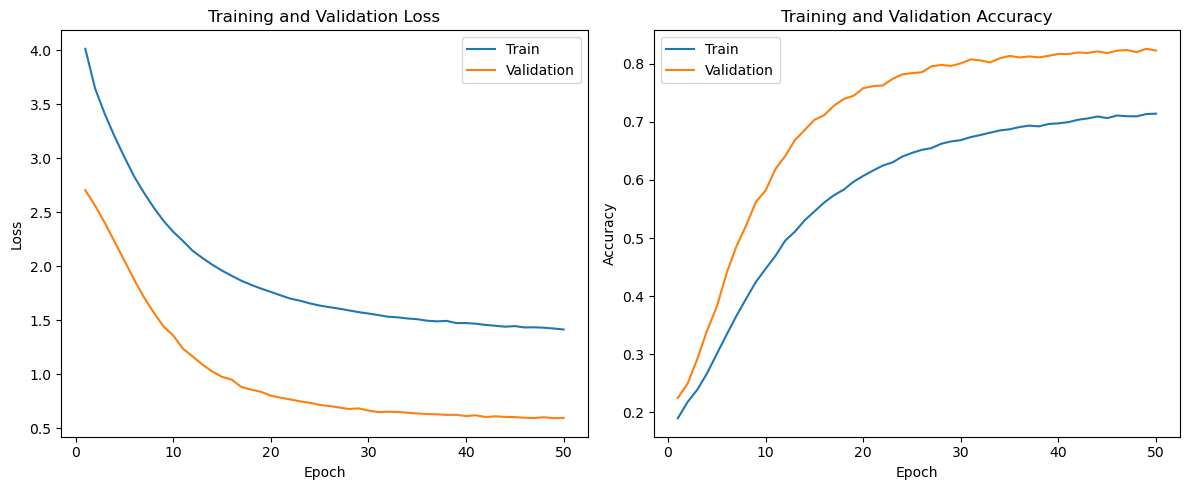

In [58]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)
    
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, epochs + 1), val_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [60]:
from generation import text_generator_greedy, text_generator_beam

sentences = ['GEN003 CIR011 CIR019 END011']
generate_length = 1
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator_beam(sentence, generate_length,SEQUENCE_LENGTH, model, word_to_int,int_to_word, device)

PROMPT: GEN003 CIR011 CIR019 END011
Predicted next diseases with probabilities:
CIR011 with probability 0.3094
GEN003 with probability 0.2960
END010 with probability 0.2943
CIR017 with probability 0.0259
END016 with probability 0.0238


Generated sequence: GEN003 CIR011 CIR019 END011 CIR011




In [61]:
sentences = ['GEN003 CIR011 CIR019 END011']
generate_length = 1

for sentence in sentences:
    print(f"Input Diseases: {sentence}")
    print("Predicted sequence of Diseases Based on the Diagnosed Diseases:")
    # def text_generator_greedy(sentence, generate_length, SEQUENCE_LENGTH, model, int_to_word, device):
    text_generator_greedy(sentence, generate_length,SEQUENCE_LENGTH, model, word_to_int,int_to_word, device)

Input Diseases: GEN003 CIR011 CIR019 END011
Predicted sequence of Diseases Based on the Diagnosed Diseases:
GEN003 CIR011 CIR019 END011 CIR011


